In [ ]:
from PIL import Image
import numpy as np
import random, glob
oi1 = np.asarray(Image.open("OptimalImage0.tif"), dtype = np.float32)
oi2 = np.asarray(Image.open("OptimalImage1.tif"), dtype = np.float32)
oi3 = np.asarray(Image.open("OptimalImage2.tif"), dtype = np.float32)
oi4 = np.asarray(Image.open("OptimalImage3.tif"), dtype = np.float32)
oi5 = np.asarray(Image.open("OptimalImage4.tif"), dtype = np.float32)
oi6 = np.asarray(Image.open("OptimalImage5.tif"), dtype = np.float32).flatten()

#print(oi6[1583, 1829])
#print(oi6[1586, 1691])
#print(oi6[1622, 1496])
#print(oi6[1622, 1352])
#cols = oi6.shape[1]*oi6.shape[0]
#np.asarray(Image.open("OptimalImage5.tif"), dtype = np.float32)
#img=np.array((6, cols))
pixel_vec = np.array(sorted(random.sample(range(0, 12288000), 15000)))
print(pixel_vec)
pixel_vec = sorted(pixel_vec)
print(pixel_vec)
print(len(oi6[pixel_vec]))
#len(set(pixel_vec))
# glob.glob("*.tif")
Z = np.zeros((6, 15000), dtype = np.float32)
Z[0]

[     668     1318     1341 ... 12282017 12287260 12287838]
[np.int64(668), np.int64(1318), np.int64(1341), np.int64(2781), np.int64(3011), np.int64(4172), np.int64(6376), np.int64(6961), np.int64(7586), np.int64(7870), np.int64(9599), np.int64(9875), np.int64(10416), np.int64(10475), np.int64(10669), np.int64(12407), np.int64(12920), np.int64(13267), np.int64(13575), np.int64(13707), np.int64(14433), np.int64(14444), np.int64(14876), np.int64(15547), np.int64(15614), np.int64(16407), np.int64(17439), np.int64(17776), np.int64(18939), np.int64(21140), np.int64(21222), np.int64(22806), np.int64(23168), np.int64(23957), np.int64(24969), np.int64(25240), np.int64(27231), np.int64(28884), np.int64(30094), np.int64(32190), np.int64(32750), np.int64(33503), np.int64(33979), np.int64(35235), np.int64(35702), np.int64(36271), np.int64(37559), np.int64(38974), np.int64(39187), np.int64(39192), np.int64(39552), np.int64(40130), np.int64(40743), np.int64(40830), np.int64(42021), np.int64(42242), 

array([0., 0., 0., ..., 0., 0., 0.], shape=(15000,), dtype=float32)

In [1]:
from PIL import Image
import numpy as np
import random, glob

def pixelValues(tif_paths, exposures, pixels):
    """
    Inputs:
        tif_paths: tif filepaths of imgages files with different exposures
        exposures: exposure in seconds for each images
        pixels: number of pixels to be sampled from each image
        length of tif files and exposures should match
    Returns a matrix with each row containing flattened image and 
    each column has a pixel value from the same pixel but differnt exposures
    """
    # tif_paths = glob.glob(os.path.join(folder, "*.tif"))
    pixel_vec = sorted(random.sample(range(0, 12288000), pixels))
    rows = len(tif_paths)
    # image_array = np.asarray(Image.open(tif_paths[0]), dtype = np.float32).shape
    # columns = image_array[0]*image_array[1]
    Z = np.zeros((pixels, rows), dtype = np.float32)
    B = np.zeros((pixels, rows), dtype = np.float32)
    for i in range(len(tif_paths)):
        raw_img = np.asarray(Image.open(tif_paths[i]), dtype = np.float32).flatten()
        Z[:, i] = raw_img[pixel_vec]
        B[:, i] = np.log(exposures[i])
    return Z, B

tif_paths = glob.glob("Optimal*.tif")
expos = [7.272, 3.636, 1.818, 0.909, 0.455, 0.228]
Z, B = pixelValues(tif_paths, expos, 15000)

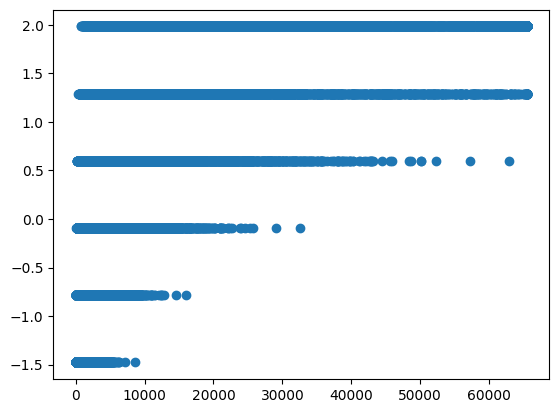

In [2]:
from matplotlib import pyplot as plt

plt.scatter(Z,B)
plt.show()

In [ ]:
import numpy as np
import torch

import gc
gc.collect()

def w(Z):
    """ 
    This is the weight function for the pixel value
    It gives mazimum weightage to the pixel values at the middle than the extreme ones
    Returns Z - Zmin if Z is less than or equal to (Zmin - Zmax)/2
    Other wise it returns Zmax - Z
    """
    return Z if Z <= 32767 else (65535-Z)

def gsolve(Z, B, l, w):
    """
    From paper: https://icg.gwu.edu/sites/g/files/zaxdzs6126/files/downloads/Recovering%20high%20dynamic%20range%20radiance%20maps%20from%20photographs.pdf
    """
    n = 65536
    # Z = Z.astype(int)
    device = torch.device("cuda")
    A = torch.zeros(Z.shape[0]*Z.shape[1]+n+1, n+Z.shape[0], dtype=torch.float)
    A = A.to(device)
    b = torch.zeros(A.shape[0], 1, dtype=torch.float)
    b = b.to(device)

    k = 0
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            wij = w(Z[i, j] + 1)
            A[k, Z[i, j] + 1] = wij
            A[k, n + i] = -wij
            b[k, 0] = wij * B[i, j]
            k = k + 1

    A[k, 32767] = 1
    k = k + 1

    for i in range(n-2):
        A[k, i] = l * w(i+1)
        A[k, i+1] = -2 * l * w(i+1)
        A[k, i+2] = l * w(i+1)
        k = k + 1
    
    #x = np.linalg.lstsq(A, b)
    x = torch.linalg.lstsq(A, b)

    g = x[0:n-1]
    lE = x[n:len(x)-1]
    return g, lE

g, lE = gsolve(Z, B, 0.1, w)



OutOfMemoryError: CUDA out of memory. Tried to allocate 46.67 GiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 23.33 GiB is allocated by PyTorch, and 3.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import scipy.sparse as sp
import scipy.sparse.linalg as lin

def w(Z):
    """ 
    This is the weight function for the pixel value
    It gives mazimum weightage to the pixel values at the middle than the extreme ones
    Returns Z - Zmin if Z is less than or equal to (Zmin - Zmax)/2
    Other wise it returns Zmax - Z
    """
    return Z if Z <= 32767 else (65535-Z)

def gsolve_scipy(Z, B, l, w):
    """
    From paper: https://icg.gwu.edu/sites/g/files/zaxdzs6126/files/downloads/Recovering%20high%20dynamic%20range%20radiance%20maps%20from%20photographs.pdf
    """
    n = 65536
    Z = Z.astype(int)
    A = sp.lil_matrix((Z.shape[0]*Z.shape[1]+n+1, n+Z.shape[0]), dtype=float)
    b = sp.lil_matrix((A.shape[0], 1), dtype=float)

    k = 0
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            wij = w(Z[i, j] + 1)
            A[k, Z[i, j] + 1] = wij
            A[k, n + i] = -wij
            b[k, 0] = wij * B[i, j]
            k = k + 1

    A[k, 32767] = 1
    k = k + 1

    for i in range(n-1):
        A[k, i] = l * w(i+1)
        A[k, i+1] = -2 * l * w(i+1)
        A[k, i+2] = l * w(i+1)
        k = k + 1
    
    x = sp.linalg.lsqr(A, b.toarray())
    g = x[0][0:n]
    lE = x[0][n:len(x[0])]

    return g, lE, x

g, lE, x = gsolve_scipy(Z, B, 2, w)

(15000,)
(15000, 6)
[[0.09214249 0.04607125 0.02303562 0.01151781 0.00576524 0.00288896]
 [0.23643364 0.11821682 0.05910841 0.02955421 0.01479336 0.00741294]
 [0.83714384 0.41857192 0.20928596 0.10464298 0.05237905 0.02624708]
 ...
 [0.9302773  0.46513864 0.23256932 0.11628466 0.05820629 0.02916711]
 [0.15445147 0.07722574 0.03861287 0.01930643 0.00966384 0.00484254]
 [1.1402113  0.5701057  0.28505284 0.14252642 0.0713416  0.0357492 ]]
15000
1472.0 704.0 336.0 144.0 80.0 16.0
65536
80536


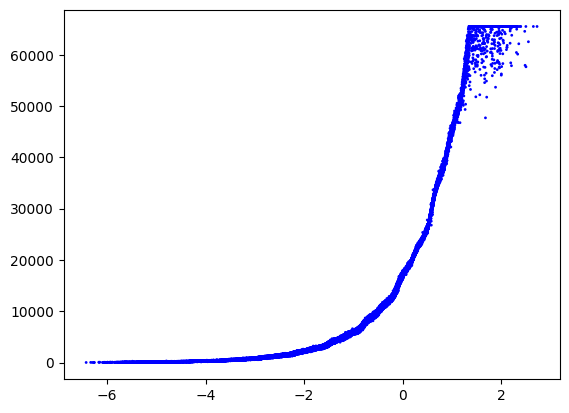

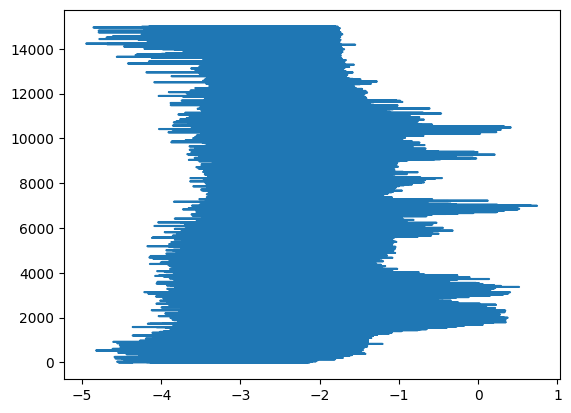

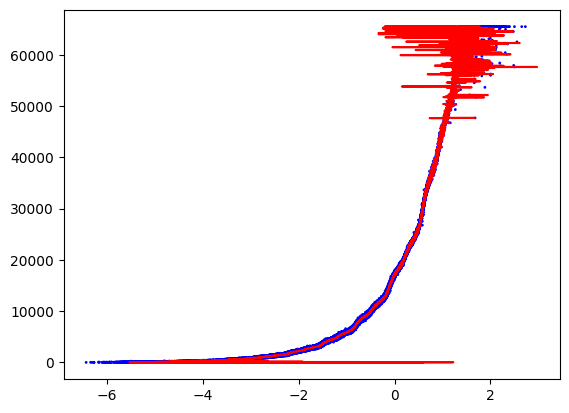

In [68]:
g1 = x[0][0:65536]
lE1 = x[0][65536:len(x[0])]
print(lE1.shape)
print(Z.shape)
lE_t_dt = np.zeros_like(Z)
for i in range(Z.shape[1]):
	lE_t_dt [:, i] = np.exp(lE1)*expos[i]
print(lE_t_dt)
print(len(lE1))
print(Z[0,0], Z[0,1], Z[0,2], Z[0,3], Z[0,4], Z[0,5])
print(len(g1))
print(len(x[0]))

plt.scatter(np.log(lE_t_dt.flatten()), Z.flatten(), s=1, marker = "o",facecolors='none', edgecolors='blue')
plt.show()
plt.plot(lE1, np.arange(15000))
plt.show()
plt.scatter(np.log(lE_t_dt.flatten()), Z.flatten(), s=1, marker = "o",facecolors='none', edgecolors='blue')
plt.plot(g1, np.arange(65536), 'r')
plt.show()


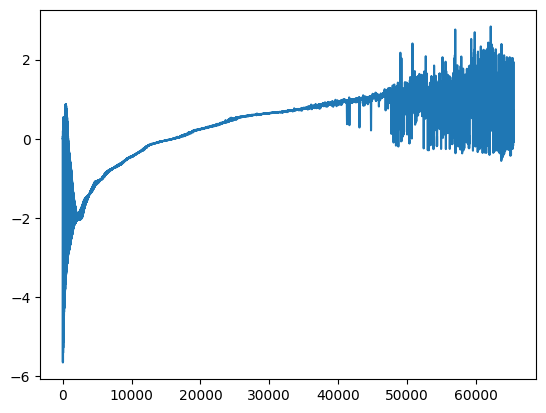

In [ ]:
g = x[0][0:n-1]
plt.plot(g)
plt.show()

In [ ]:
import scipy.sparse as sp
import scipy.sparse.linalg as lin

def w(Z):
    """ 
    This is the weight function for the pixel value
    It gives mazimum weightage to the pixel values at the middle than the extreme ones
    Returns Z - Zmin if Z is less than or equal to (Zmin - Zmax)/2
    Other wise it returns Zmax - Z
    """
    return Z if Z <= 32767 else (65535-Z)

def gsolve_scipy(Z, B, l, w):
    """
    From paper: https://icg.gwu.edu/sites/g/files/zaxdzs6126/files/downloads/Recovering%20high%20dynamic%20range%20radiance%20maps%20from%20photographs.pdf
    """
    n = 65536
    Z = Z.astype(int)
    A = sp.lil_matrix((Z.shape[0]*Z.shape[1]+n+1, n+Z.shape[0]), dtype=float)
    b = sp.lil_matrix((A.shape[0], 1), dtype=float)

    k = 0
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            wij = w(Z[i, j] + 1)
            A[k, Z[i, j] + 1] = wij
            A[k, n + i] = -wij
            b[k, 0] = wij * B[i, j]
            k = k + 1

    A[k, 32767] = 1
    k = k + 1

    for i in range(n-2):
        A[k, i] = l * w(i+1)
        A[k, i+1] = -2 * l * w(i+1)
        A[k, i+2] = l * w(i+1)
        k = k + 1
    
    x = sp.linalg.lsqr(A, b.toarray())
    g = x[0][0:n-1]
    lE = x[0][n:len(x[0])-1]

    return g, lE

def pixelValues(tif_paths, exposures, pixels):
    """
    Inputs:
        tif_paths: tif filepaths of imgages files with different exposures
        exposures: exposure in seconds for each images
        pixels: number of pixels to be sampled from each image
        length of tif files and exposures should match
    Returns a matrix with each row containing flattened image and 
    each column has a pixel value from the same pixel but differnt exposures
    """
    # tif_paths = glob.glob(os.path.join(folder, "*.tif"))
    pixel_vec = sorted(random.sample(range(0, 12288000), pixels))
    rows = len(tif_paths)
    # image_array = np.asarray(Image.open(tif_paths[0]), dtype = np.float32).shape
    # columns = image_array[0]*image_array[1]
    Z = np.zeros((pixels, rows), dtype = np.float32)
    B = np.zeros((pixels, rows), dtype = np.float32)
    raw_images = []
    for i in range(len(tif_paths)):
        raw_img = np.asarray(Image.open(tif_paths[i]), dtype = np.float32).flatten()
        Z[:, i] = raw_img[pixel_vec]
        B[:, i] = np.log(exposures[i])
        raw_images.append(raw_img)
    return Z, B, np.array(raw_images)

tif_paths = glob.glob("Optimal*.tif")
expos = [7.272, 3.636, 1.818, 0.909, 0.455, 0.228]
Z, B, raw_imgs = pixelValues(tif_paths, expos, 15000)
g1, lE = gsolve_scipy(Z, B, 0.1, w)
g9, lE = gsolve_scipy(Z, B, 0.9, w)


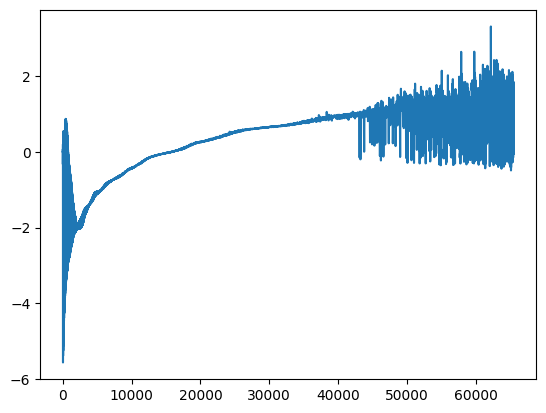

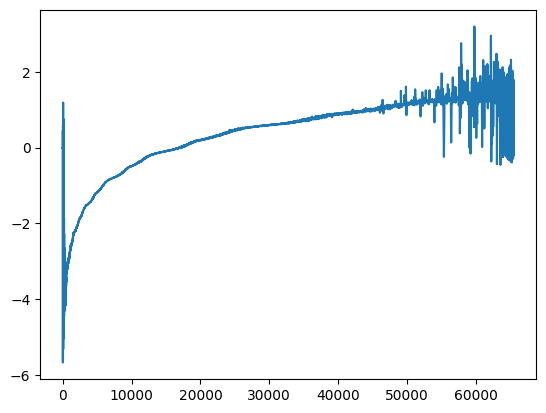

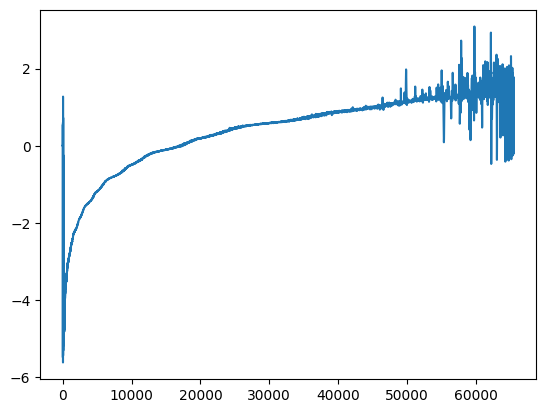

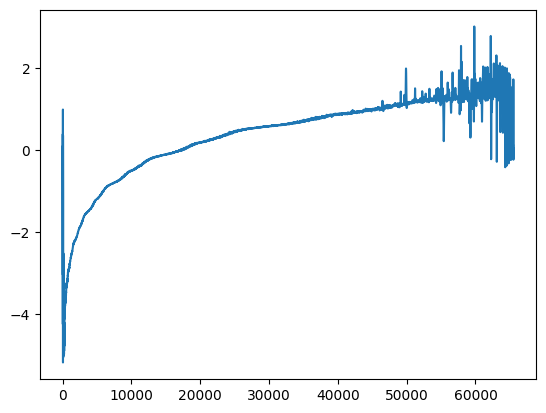

In [ ]:
g100, lE = gsolve_scipy(Z, B, 10, w)
plt.plot(g1)
plt.show()
plt.plot(g9)
plt.show()
plt.plot(g20)
plt.show()
plt.plot(g100)
plt.show()

In [ ]:
# This script constructs HDR from the CRF function
raw_imgs = raw_imgs.astype(int)
HDR_img = np.zeros((len(raw_imgs[0]), 1), dtype=np.float32)
num = 0
den = 0
for i in range(raw_imgs.shape[1]):
    for j in range(raw_imgs.shape[0]):
        num = num + w(raw_imgs[j, i]) * (g[raw_imgs[j,i]] - np.log(expos[j]))
        den = den + w(raw_imgs[j, i])
        if j == raw_imgs.shape[0]-1:
            HDR_img[i, 0] = num / den
            num = 0
            den = 0
        

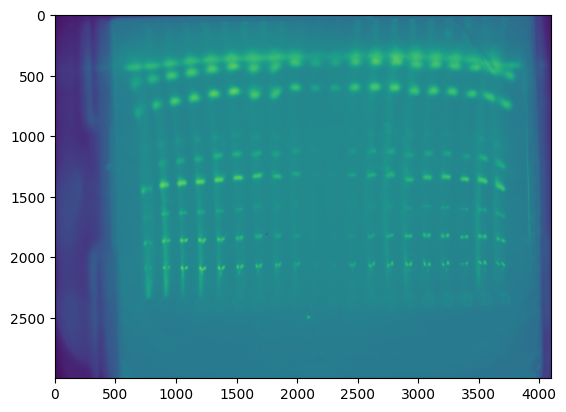

In [ ]:
# reshapes and plots the HDR image
import matplotlib.pyplot as plt
HDR_pic = HDR_img.reshape((3000, 4096))
plt.imshow(HDR_pic)
plt.show()
HDR_pic1 = Image.fromarray(HDR_pic)
HDR_pic1.save("HDR.tif")

In [ ]:
print(Z.shape)
print(B.shape)
print(raw_imgs.shape)

(15000, 6)
(15000, 6)
(6, 12288000)


In [ ]:
trans = np.transpose(raw_imgs)
print(np.transpose(raw_imgs).shape)
print(trans[10110, :])
print(raw_imgs[:, 10110])

(12288000, 6)
[11232  5536  2608  1296   576   384]
[11232  5536  2608  1296   576   384]


In [ ]:
# Pile of BS
from skimage import io
import os

tif_paths = glob.glob("Images/*.tif")
tif_paths.sort(key=os.path.getmtime)
images = []
acquisitions = [6, 7, 8, 9, 10, 11, 30, 31, 32, 33, 34, 35]
images = [np.asarray(Image.open(x), dtype=np.float32) for x in tif_paths]
for i in range(len(acquisitions):
    average_img = (images[acquisitions[i]] + images[acquisitions[i]+6]
                   + images[acquisitions[i]+12] + images[acquisitions[i]+18])/4
    savefile = Image.fromarray(average_img.astype(np.uint16))
    fname = 'Average' + str(i) +'.tif'
    savefile.save(fname)

for i in range(len(acquisitions)):
	file_num = acquisitions[i] + 6
	images.append(io.imread(tif_paths[file_num], plugin = 'pil'))
	#  images.append(io.imread(glob.glob(os.path.join(dirname, file))[0], plugin = 'pil'))
sum_Images = np.empty_like(images[0])
for i in range(len(images)):
	sum_Images = sum_Images + images[i].astype(np.float32) if sum_Images.size != 0 else images[i]
Average_Image = sum_Images / len(images)


blank_substract = []
for i in range(4):
    for j in range(6):
        raw_signal = np.asarray(Image.open(tif_paths[(6*(i+5)+j)]), dtype = np.float32)
        blank_signal = np.asarray(Image.open(tif_paths[(6*(i+1)+j)]), dtype = np.float32)
        substract = raw_signal.astype(np.float32) - blank_signal.astype(np.float32)
        substract[substract < 0] = 0
        blank_substract.append(substract)
avg_imgs = []
for i in range(12):
    average_img = (blank_substract[i].astype(np.float32) + blank_substract[i+6].astype(np.float32)
                     + blank_substract[i+12].astype(np.float32) + blank_substract[i+18].astype(np.float32))/4
    fname = 'Average' + str(i) +'.tif'
    savefile = Image.fromarray(average_img.astype(np.uint16))
    savefile.save(fname)

for i in range(len(avg_imgs)):
    

In [ ]:
# Makes 12 average images using 48 raw images 
import numpy as np
import os, glob
from PIL import Image
tif_paths = glob.glob("Images/*.tif")
tif_paths.sort(key=os.path.getmtime)
images = []
acquisitions = [6, 7, 8, 9, 10, 11, 30, 31, 32, 33, 34, 35]
images = [np.asarray(Image.open(x), dtype=np.float32) for x in tif_paths]
for i in range(len(acquisitions)):
    average_img = (images[acquisitions[i]] + images[acquisitions[i]+6]
                   + images[acquisitions[i]+12] + images[acquisitions[i]+18])/4
    savefile = Image.fromarray(average_img.astype(np.uint16))
    fname = 'Average' + str(i) +'.tif'
    savefile.save(fname)